<a href="https://colab.research.google.com/github/IshtiSikder/Optimal-allocation-of-rescue-teams-for-hostage-situations/blob/final/R_for_MDP_(NEW).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [57]:
# CTMC MDP model for rescue operational system!!!
# For steady state prob for optimal policy
prob <- function(opSet = policySet, t, lam, eps, mu) {
  opTRM = matrix(0, nrow = t+1, ncol = t+1)
  for (i in 2:t) {
    opTRM[i, i-1] = sum(i*eps, opSet[i]*mu)
    opTRM[i, i+1] = lam      
  }
  opTRM[1, 2] = lam
  opTRM[t+1, t] = sum(t*eps, opSet[t+1]*mu)
  
  k = t+1
  steady_prob <- matrix(0, nrow=1, ncol=k)
  state <- matrix(0, nrow=1, ncol=k-1)
  for (i in 1:(k-1)) {
    if (i-2 < 0) {
      state[i] <- (lam/opTRM[i+1,i])
    } else {
      state[i] <- state[i-1]*(lam/opTRM[i+1,i])
    }
  }
  
  steady_prob[1] <- (1+sum(state))^-1
  for (i in 2:k) {
    steady_prob[i] <- state[i-1]*steady_prob[1]
  }
  return(steady_prob)
}

# Check function to determine new policy is same with current or not 
checkPolicy = function(policySet, policySetnew) {
  n = 0
  for (i in policySet == policySetnew) {
    if (i == 'FALSE') {
      n = 1
    } 
  } 
  if (n == 0) {
    return("TRUE")
  } else {
    return("FALSE")
  }
} 

rewardR <- function(costR, RC, nr) {
  if (RC == "SR") {
    if (costR < 0) {
      result = -sqrt(-costR * nr)      
    } else {
      result = sqrt(costR * nr)
    }
  } else if (RC == "L") {
    result = costR * nr      
  } else {
    if (costR < 0) {
      result = -(costR * nr)^2      
    } else {
      result = (costR * nr)^2      
    }
  }
  return(result)
}

rewardT <- function(costT, TC, nt) {
  if (TC == "SR") {
    if (costT < 0) {
      result = -sqrt(-costT * nt)      
    } else {
      result = sqrt(costT * nt)
    }
  } else if (TC == "L") {
    result = costT * nt      
  } else {
    if (costT < 0) {
      result = -(costT * nt)^2      
    } else {
      result = (costT * nt)^2      
    }
  }
  return(result)
}

#########################################################
#EDITS: 22ND FEB,2023
#NEW SERVICE RATE STRUCTURE. ADD ORIGINAL ONE AS WELL
probR = function(nr, nt, eps, mu, SR) {
  #if (nt == 0 & nr == 0) {
  if (nt == 0){
    result = 0
  } else {
    if(SR=='ORG'){
      result = nr*mu / (nr*mu + nt*eps)
    }
    else {
    result = min(nr,nt)*mu / (min(nr,nt)*mu + nt*eps)
  }
  return(result)
}
}
#########################################################

# Define MDP function (for basic policy)
MDP = function(lam, mu, eps, numRescue, numTerror, costR, costT, RC, TC, SR) {
  r = numRescue
  t = numTerror
  # Design the three dimension matrix(i,j,k)
  # k: Index of rescue team
  # i: state(current)
  # j: state(next)
  
  
  #########################################################
  #EDITS: 22ND FEB,2023
  #NEW SERVICE RATES STRUCTURE, ADD ORIGINAL ONE AS WELL
  aijMatrix = array(0, dim = c(t+1,t+1,r+1))

for (i in 1:t){
  for (k in 1:(r+1)){
    if (k <= i){
      aijMatrix[i,i+1,k] <- lam
    }
  }
}

for (i in 2:t){
  for (k in 1:(r+1)){
    if (k <= i){
      if (SR=='ORG'){
          aijMatrix[i,i-1,k] <- sum((k-1)*mu+(i-1)*eps)
            }
          else { 
        aijMatrix[i,i-1,k] <- sum(min(k-1,i-1)*mu+(i-1)*eps)        
      }
    }
  }
  }


for (k in 1:(r+1)){
  if (k <= (t+1)){
  if (SR=='ORG'){
      aijMatrix[t+1,t,k] <- ((k-1)*mu+t*eps)
    }
    else {
      aijMatrix[t+1,t,k] <- (min(k-1,t)*mu+t*eps)
    }
  }
}

for (i in 1:(t+1)) {
    for (k in 1:(r+1)) {
      if (k<=i){
      aijMatrix[i,i,k] <- -sum(aijMatrix[i,,k])      
    }
    }
  }

  #########################################################
  
  #print(aijMatrix[4,4,5])
  #cat('meu',mu)
  #cat('epsilon',eps)
  #break
  
  
  # Design the MDP algorithm
  # Value determination
  policy = array(0, dim = c(1,t+1)) 
  policyOld = array(3, dim = c(1,t+1))
  policyNew = array(1, dim=c(1,t+1)) # initially set all decision is 1 in first policy
  policyTrack = array(2, dim=c(1,t+1))
  iteration = 0
  gainMatrix = c()
  
  while (checkPolicy(policyOld, policyNew) == 'FALSE') {
    policyOld = policyNew
    policy = policyNew
    # Design the transition matrix regarding policy
    A = array(0, dim = c(t+1,t+1))
    for (i in 1:length(policy)) {
      A[i,] = aijMatrix[i,,(policy[i])]  
    }

    # Design the cost matrix regarding policy
    q = array(0, dim = c(t+1,1))
    for (i in 1:length(policy)) {
      cost = probR(nr=(policy[i]-1),nt=(i-1),eps,mu,SR)*rewardR(costR, RC, nr=(policy[i]-1))+
        (1-probR(nr=(policy[i]-1),nt=(i-1),eps,mu,SR))*rewardT(costT, TC, nt=(i-1))
      q[i,1] = cost
    }
    newA = cbind(array(1, dim=c(t+1,1)), -A[,1:t])
    solution = solve(newA) %*% q
    gain = solution[1] # First row of solution is gain value
    gainMatrix = append(gainMatrix, gain)
    
    # Policy improvement
    newsolution = array(0, dim=c(t+1,1))
    for (i in 1:t) {
      newsolution[i] = solution[i+1]
    }
    newsolution[t+1] = 0 # Set last v value as 0 to calcultate the test quantity in policy improvement
    improveMatrix = array(0, dim=c(t+1,r+1))
    for (i in 1:(t+1)) {
      for (j in 1:(r+1)) {
        if (j<=i){
        # Cost when we have j rescue operation and i terrorists
        cost = probR(nr=(j-1),nt=(i-1),eps,mu,SR)*rewardR(costR, RC, nr=(j-1))+
          (1-probR(nr=(j-1),nt=(i-1),eps,mu,SR))*rewardT(costT, TC, nt=(i-1))
        improveMatrix[i,j] = cost + aijMatrix[i,,j] %*% newsolution
        }
        else{improveMatrix[i,j] = 100000000000}
      }
    }  
    
    # pick the minimum value among the decision
    policyNew = array(1, dim = c(1,t+1))
    for (i in 1:length(policyNew)) {
      policyNew[i] = which.min(improveMatrix[i,])
    }
    iteration = iteration + 1
    policyTrack = rbind(policyTrack, policyNew)
    policyNew
  }
  for (i in 1:length(policyNew)) {
    policyNew[i] = policyNew[i] - 1
  }
  for (i in 1:nrow(policyTrack)) {
    for (j in 1:ncol(policyTrack)) {
      policyTrack[i,j] = policyTrack[i,j] - 1      
    }

  }

  # stateName = c()
  # for (i in 1:(t+1)) {
  #   stateName = append(stateName, paste('terror',(i-1)))
  # }
  # Steady_prob = prob(opSet = policyNew, t, lam, eps, mu)  
  # colnames(policyTrack) = stateName
  # colnames(policyNew) = stateName
  # colnames(Steady_prob) = stateName
  # rownames(Steady_prob) = 'Probability'
  # rownames(policyNew) = 'Decision'
  # result <- list("Iteration" = iteration,
  #                "PolicyChange" = policyTrack,
  #                "Gain" = gainMatrix,
  #                "SteadyStateProb" = Steady_prob,
  #                "Optimal_policy" = policyNew)
  
  return(policyNew)
 
}

MDP(lam = 0.2763, mu = 0.2829, eps = 0.1718, numRescue=10, numTerror=10, costR=5, costT=1, RC="QD", TC="QD",SR='UP')

0,0,0,1,1,1,1,1,1,1,2


In [ ]:
#A = MDP(lam = 0.3546, mu = 0.2829, eps = 0.1718, numRescue=10, numTerror=10, costR=1, costT=1, RC="L", TC="L",SR='UP')




# # 1 more iteration for example plot
# library(ggplot2)
# result = MDP(lam = 0.2473, mu = 0.2829, eps = 0.1718, numRescue=3, numTerror=5, costR=1, costT=2, RC="L", TC="L",SR="UP")
# result = result$Gain
# ddd = array(0, dim=c(5,2))
# for (i in 1:5) {
#   ddd[i,1] = i
#   ddd[i,2] = result[i]  
# }
# ddd[5,1] = 5
# ddd[5,2] = ddd[4,2]

# ddd = as.data.frame(ddd)
# ggplot(ddd, aes(x=V1, y=V2)) +
#   geom_line(size=1) +
#   labs(x = 'Number of iteration', y = 'Gain value',
#        title = 'Gain value change during iterations')


# # Experiment design
# rescueSet = c(1,2,3,4,5,6,7,8,9,10)
# gainResult = array(0, dim=c(5,length(rescueSet)))
# for (j in 1:5) {
#   for (i in 1:length(rescueSet)) {
#     val = rescueSet[i]
#     result = MDP(lam=0.2473, mu=0.2829, eps=0.1718, numRescue=val, numTerror=10, costR=1, costT=j, RC="L", TC="L",SR='UP')
#     gainResult[j,i] = tail(result$Gain, 1)
#   }  
# }
# gainResult = as.data.frame(t(gainResult))
# gainResult$index = rescueSet
# ggplot() +
#   geom_line(data=gainResult, aes(x=index, y=V1, color='black'), size=1) +
#   geom_line(data=gainResult, aes(x=index, y=V2, color='red'), size=1) +
#   geom_line(data=gainResult, aes(x=index, y=V3, color='blue'), size=1) +
#   geom_line(data=gainResult, aes(x=index, y=V4, color='purple'), size=1) +
#   geom_line(data=gainResult, aes(x=index, y=V5, color='green'), size=1) +
#   labs(x = 'Rescue forces capacity', y = 'Gain value of the system',
#        title = 'Gain of the system over rescue team capacity') +
#   scale_color_identity(name = "Terror cost",
#                        labels = c("cost=1", "cost=2", "cost=3", "cost=4", "cost=5"),
#                        breaks = c("black", "red", "blue", "purple", "green"),
#                        guide = "legend")


In [72]:
vis = function(lam,mu,eps,numRescue,numTerror,costR,costT,SR){
for (rc in list('SR','L','QD')) {
  for (tc in list('SR','L','QD')) {
    #cat('(RC,TC): (',rc,',',tc,')','\n\n')
    A = MDP(lam = lam, mu = mu, eps = eps, numRescue=numRescue, numTerror=numTerror, costR=costR, costT=costT, RC=rc, TC=tc,SR=SR)
    #print(A)
    #cat('\n\n')
    cost_res = array(0,dim=c(1,numTerror+1))
    cost_ter = array(0,dim=c(1,numTerror+1))
    for (i in 1:(numTerror+1)){
      cost_res[1,i] = rewardR(costR=costR, RC=rc, nr=A[1,i])
      cost_ter[1,i] = rewardT(costT=costT, TC=tc, nt=i)
    }

    # Graph cars using a y axis that ranges from 0 to 12
    plot(array(cost_res), type="o", col="blue", ylim=c(0,20))

    # Graph trucks with red dashed line and square points
    lines(array(cost_ter), type="o", pch=22, lty=2, col="red")

    # Create a title with a red, bold/italic font
    title(main= paste("(RC,TC): ( ", rc, " , ", tc,')', sep = ""), col.main="red", font.main=4)

    #cat('(RC,TC): (',rc,',',tc,')','\n')

  }
}
}

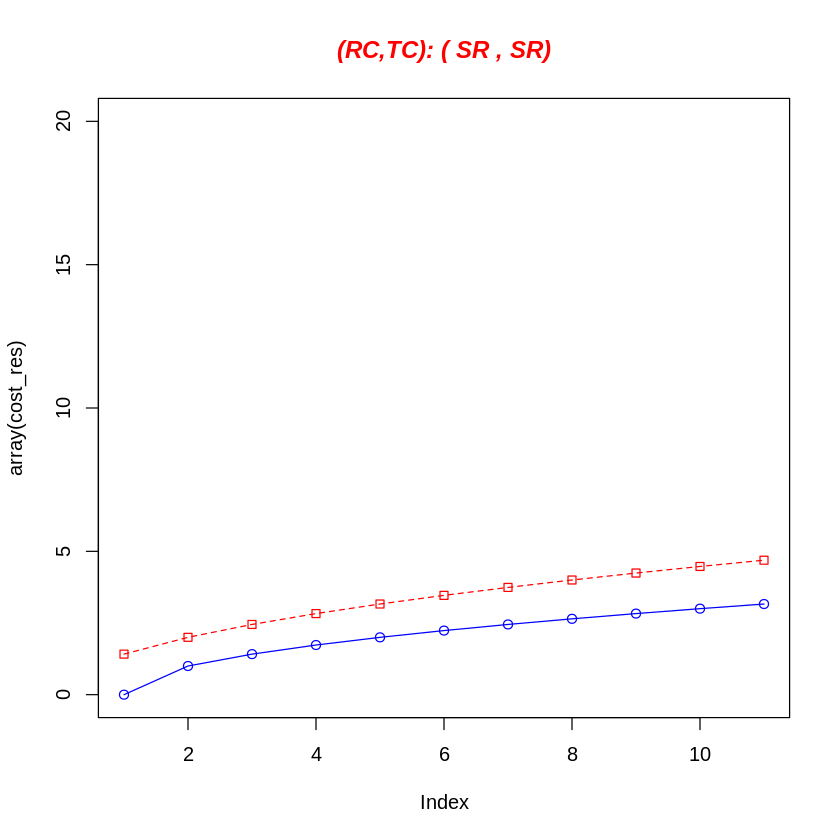

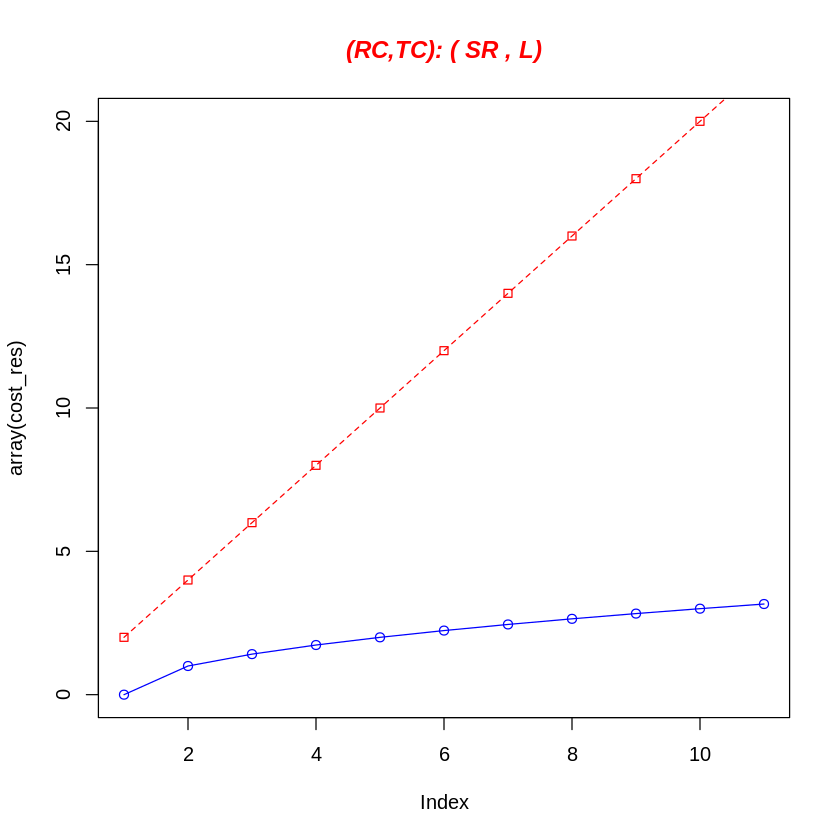

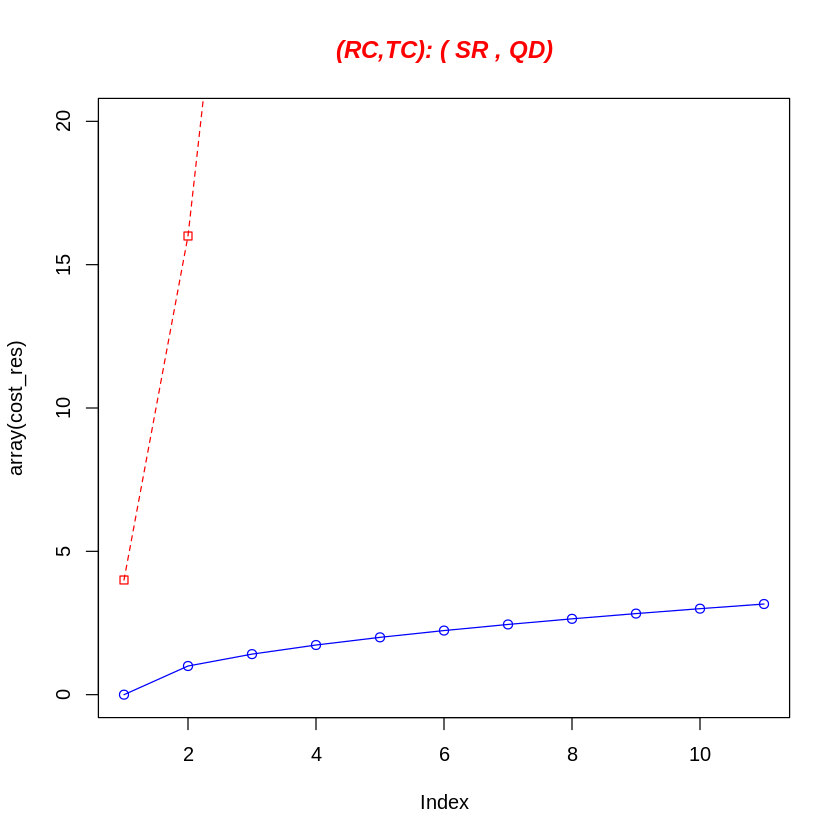

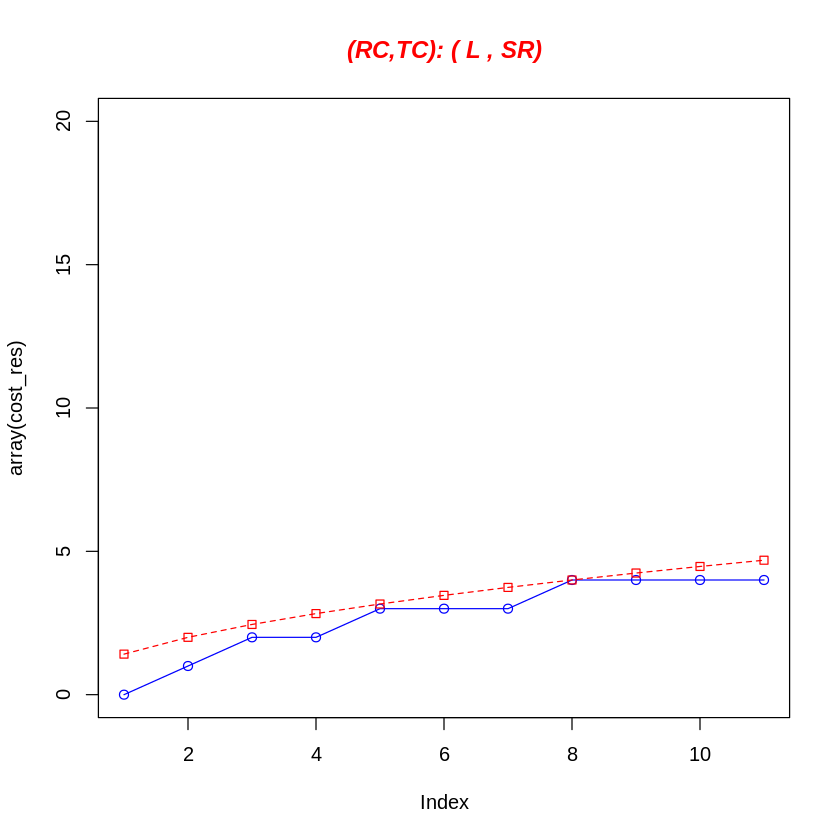

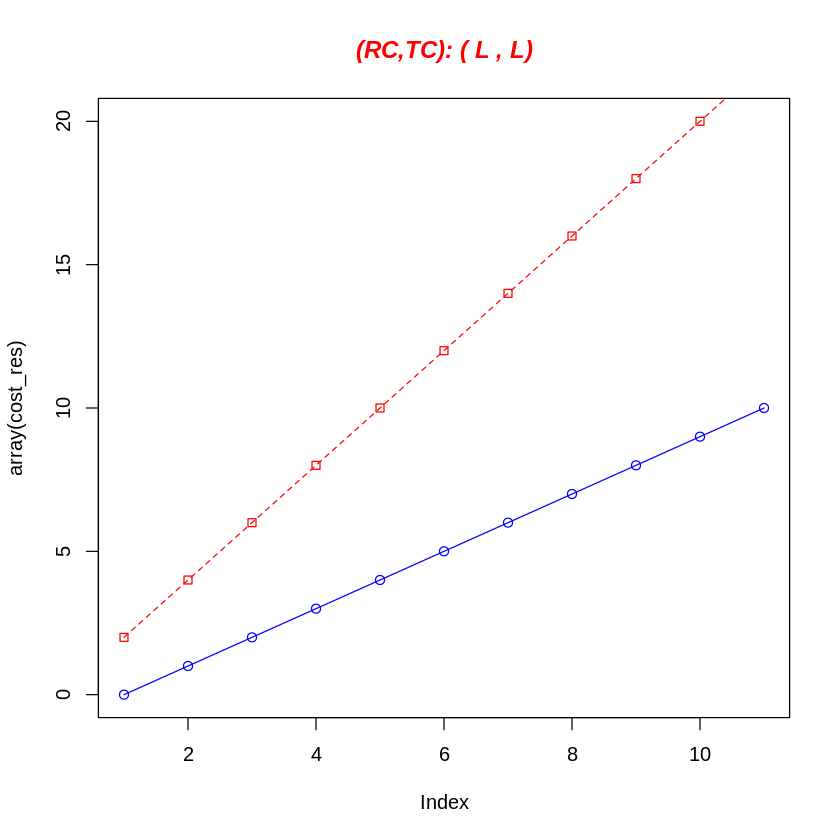

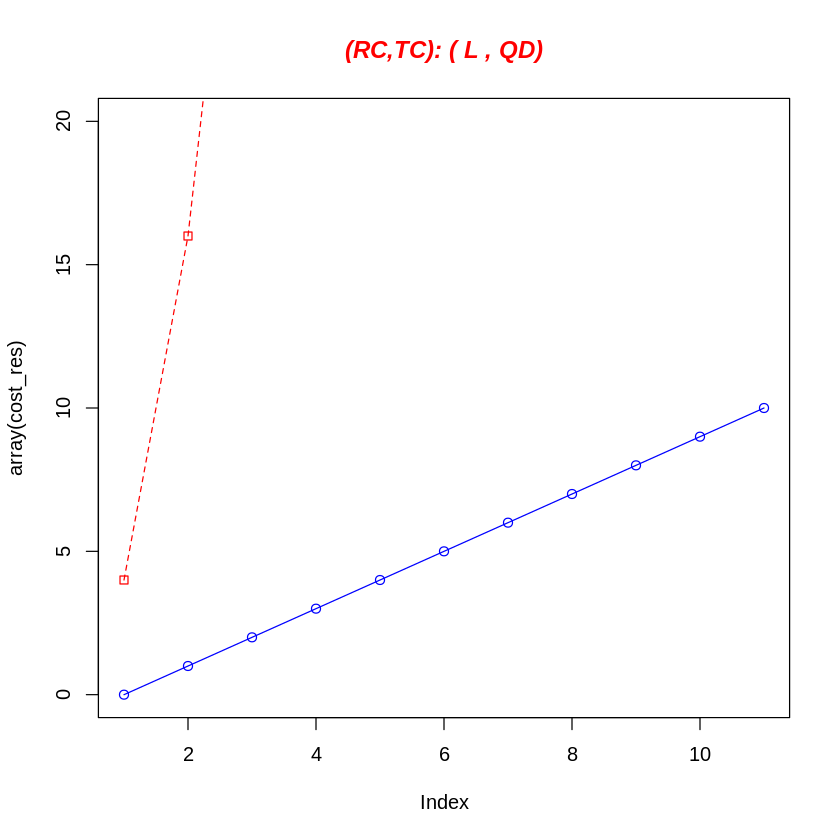

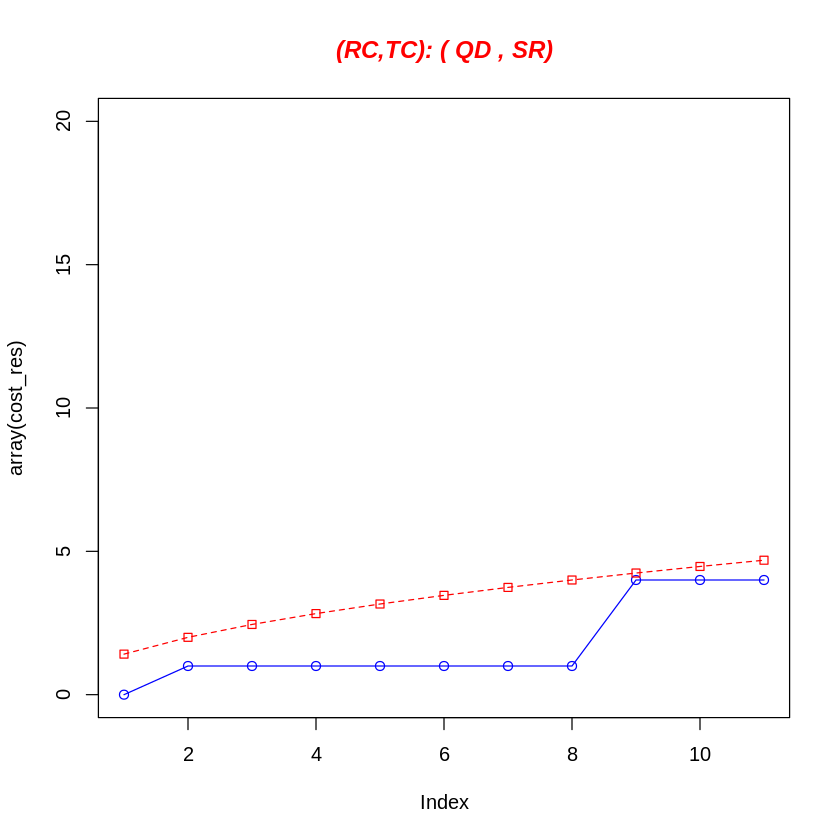

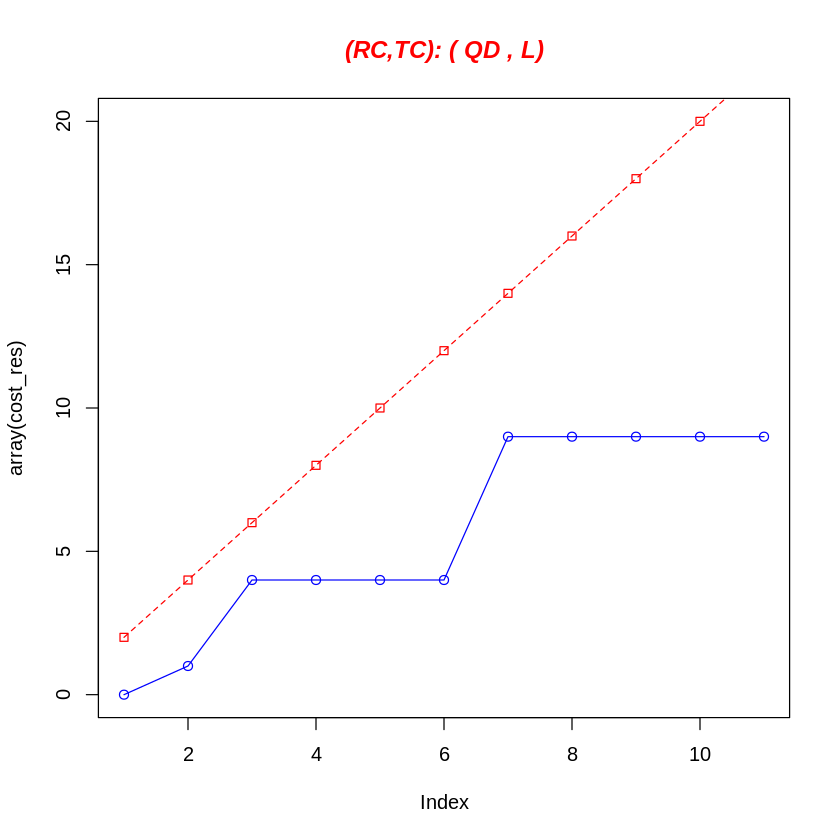

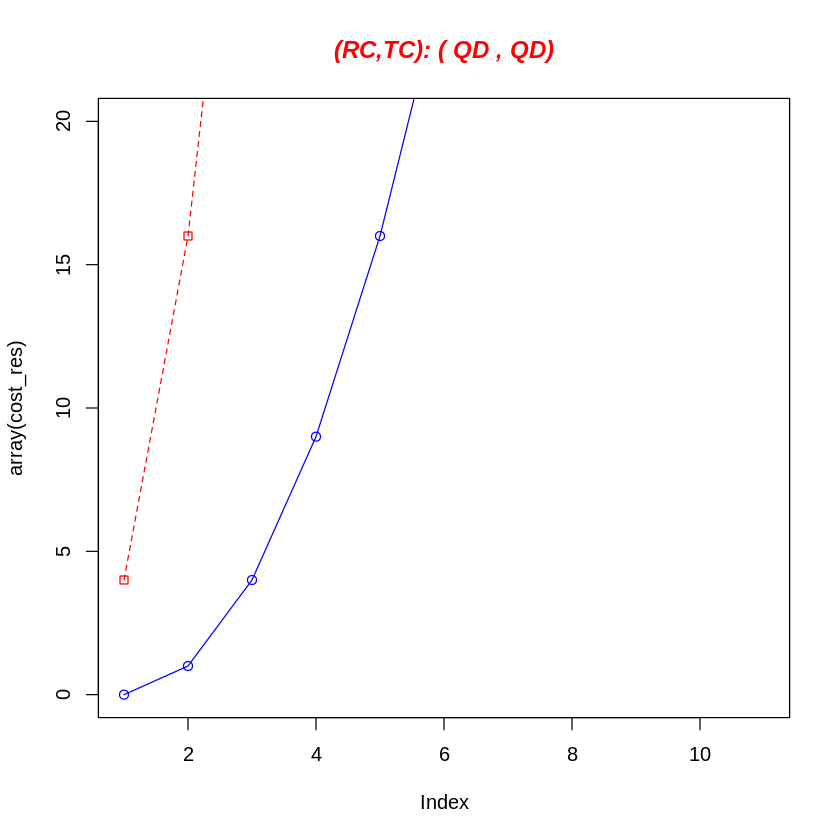

In [73]:
vis(lam = 0.2763, mu = 0.2829, eps = 0.1718, numRescue=10, numTerror=10, costR=1, costT=2,SR='UP')

In [43]:
for (i in test){
  print(i)
}

[1] 0
[1] 1
[1] 2
[1] 3
[1] 4
[1] 5
[1] 6
[1] 7
[1] 8
[1] 9
[1] 10


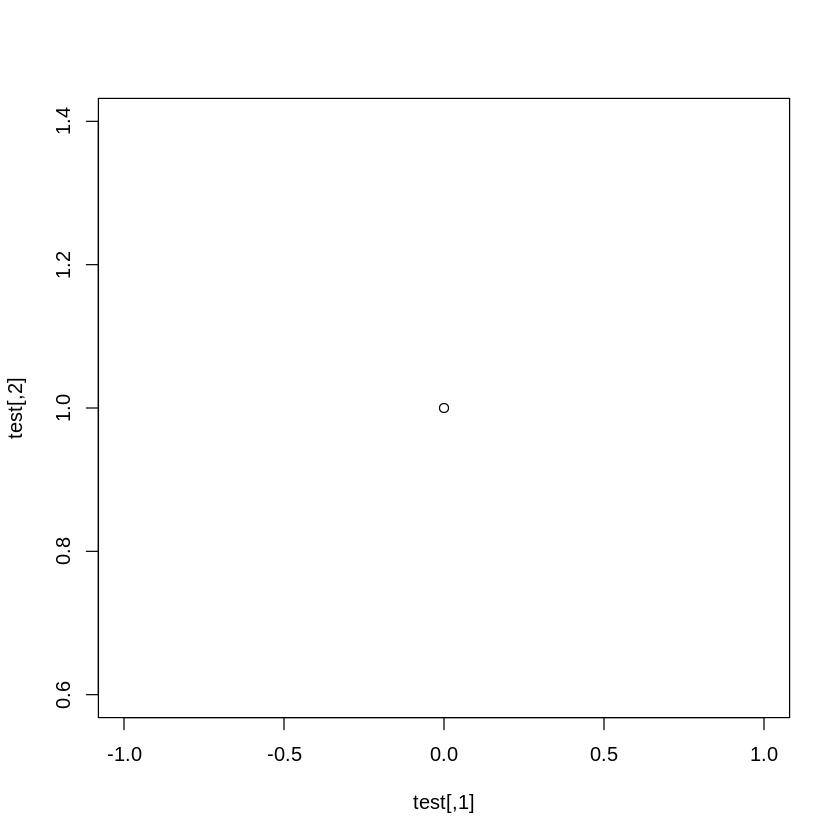

In [35]:
plot(test)

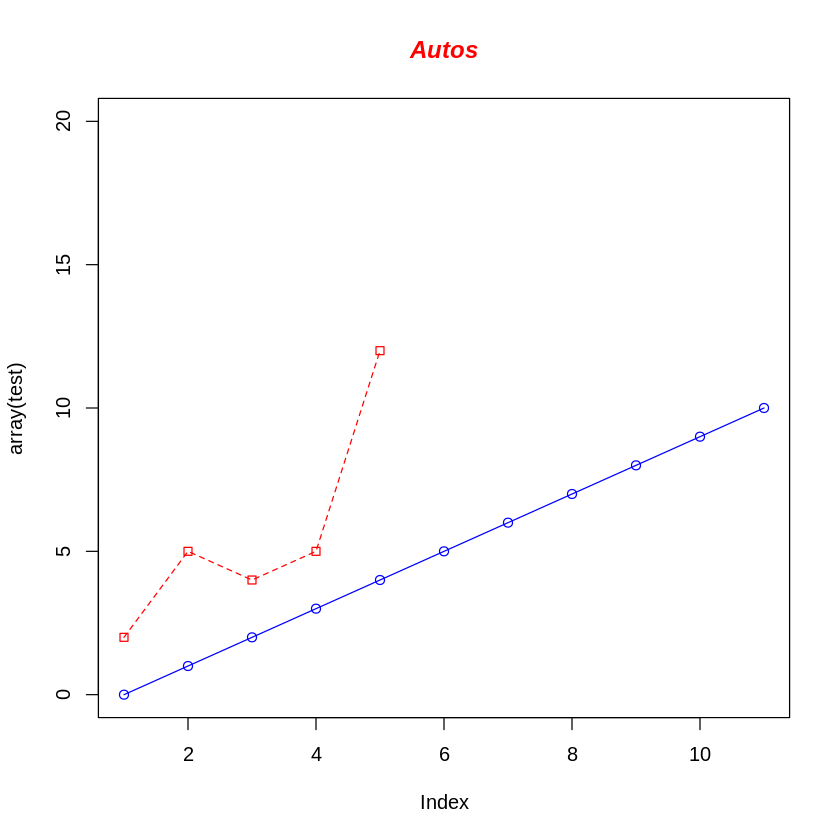

In [42]:
# Define 2 vectors
#cars <- c(1, 3, 6, 4, 9,10)
trucks <- c(2, 5, 4, 5, 12)

# Graph cars using a y axis that ranges from 0 to 12
plot(array(test), type="o", col="blue", ylim=c(0,20))

# Graph trucks with red dashed line and square points
lines(trucks, type="o", pch=22, lty=2, col="red")

# Create a title with a red, bold/italic font
title(main="Autos", col.main="red", font.main=4)

In [40]:
array(test)

[1]  0  1  2  3  4  5  6  7  8  9 10